In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from bs4 import BeautifulSoup
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

## Logistic Regression

In [ ]:
from google.colab import drive

# Step 1: Load the Data
drive.mount('/content/drive')
data_path = ('/content/drive/MyDrive/Yale 2024-2025/LING227_Final/amazon_review.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Read data
# Output 5 rows of data
reviews = pd.read_csv(data_path)
print(reviews.head())

       reviewerID        asin  reviewerName helpful  \
0  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
1  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
2  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
3   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
4  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                          reviewText  overall  \
0                                         No issues.      4.0   
1  Purchased this for my device, it worked as adv...      5.0   
2  it works as expected. I should have sprung for...      4.0   
3  This think has worked out great.Had a diff. br...      5.0   
4  Bought it with Retail Packaging, arrived legit...      5.0   

                                  summary  unixReviewTime  reviewTime  \
0                              Four Stars      1406073600  2014-07-23   
1                           MOAR SPACE!!!      1382659200  2013-10-25   
2               nothing to really say....      1356220800  

In [ ]:
# Read in relevant columns
reviews = reviews[['reviewerID','reviewText', 'summary', 'day_diff','helpful','overall']]  # Adjust column names as needed
# Drop rows where reviewText is missing
reviews = reviews[reviews['reviewText'].notna()]
# Reset the index to ensure it adjusts dynamically
reviews.reset_index(drop=True, inplace=True)

In [ ]:
# Step 3: Preprocess 'helpful' column
# Split 'helpful' into helpful_yes and total_vote
reviews[['helpful_yes', 'total_vote']] = reviews['helpful'].str.strip('[]').str.split(',', expand=True).astype(int)
reviews['helpful_ratio'] = reviews['helpful_yes'] / (reviews['total_vote'] + 1)  # Avoid division by zero

In [ ]:
# Step 4: Clean the reviewText and summary using BeautifulSoup
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

reviews['cleaned_review'] = reviews['reviewText'].apply(text_cleaning)
reviews['cleaned_summary'] = reviews['summary'].apply(text_cleaning)

<ipython-input-19-e890b14d2a15>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-19-e890b14d2a15>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
# Step 5: Convert text features to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=1000) # max_feature was set to 20% of dataset
#tfidf = TfidfVectorizer(max_features=2000) # max_feature experiment -> showed worse values
#tfidf = TfidfVectorizer(max_features=3000) # max_feature experiment -> showed worse values
reviewText_tfidf = tfidf.fit_transform(reviews['cleaned_review']).toarray()
summary_tfidf = tfidf.fit_transform(reviews['cleaned_summary']).toarray()

In [ ]:
# Step 6: Normalize numerical features
scaler = MinMaxScaler()
numerical_features = reviews[['helpful_ratio', 'day_diff']]
scaled_numerical = scaler.fit_transform(numerical_features)

In [ ]:
# Step 7: Combine all features
X = np.hstack((reviewText_tfidf, summary_tfidf, scaled_numerical))  # Combine text and numerical features
y = reviews['overall'].astype(int)  # Target variable (ratings 1–5)

In [ ]:
# Step 8: Split the dataset into training and testing sets
# Test size is 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3931, 2002), (983, 2002), (3931,), (983,))

In [ ]:
# Step 9: Train a logistic regression model with regularization
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1, random_state=42)
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=1, multi_class='multinomial', random_state=42)

In [ ]:
# Step 10: Make predictions and evaluate the model
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8240081383519837

Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.55      0.61        49
           2       0.00      0.00      0.00        16
           3       0.14      0.04      0.06        28
           4       0.28      0.05      0.08       106
           5       0.85      0.99      0.91       784

    accuracy                           0.82       983
   macro avg       0.39      0.32      0.33       983
weighted avg       0.74      0.82      0.77       983



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Print the first few values of y_test, y_pred, and corresponding reviewerText
print("y_test values:")
for i in range(5):
    print(f"Index: {i}")
    print(f"y_test: {y_test.iloc[i]}")
    print(f"ReviewText: {reviews.iloc[i]['reviewText']}")

print("\ny_pred values:")
for i in range(5):  # Print first few predicted values
    print(f"Index: {i}")
    print(f"y_pred: {y_pred[i]}")
    print(f"ReviewText: {reviews.iloc[i]['reviewText']}")

y_test values:
Index: 0
y_test: 4
ReviewText: No issues.
Index: 1
y_test: 5
ReviewText: Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.
Index: 2
y_test: 5
ReviewText: it works as expected. I should have sprung for the higher capacity.  I think its made a bit cheesier than the earlier versions; the paint looks not as clean as before
Index: 3
y_test: 5
ReviewText: This think has worked out great.Had a diff. bran 64gb card and if went south after 3 months.This one has held up pretty well since I had my S3, now on my Note3.*** update 3/21/14I've had this for a few months and have had ZERO issue's since it was transferred from my S3 to my Note3 and into a note2. This card is reliable and solid!Cheers!
Index: 4
y_test: 5
ReviewText: Bought it with Retail Packaging, arrived legit, in a orange envelope, english version not asian like the picture shows. arrived quickly, bought a 32 and

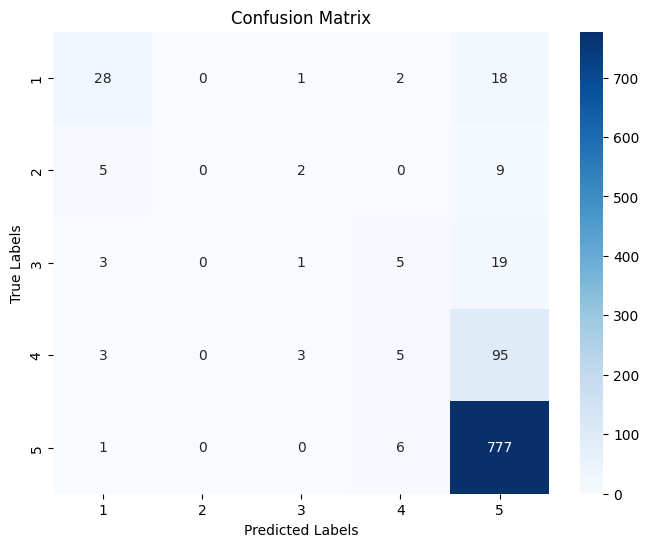

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 11: Confusion Matrix
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Identify mismatch indices
mismatch_indices = np.where((y_pred == 5) & (y_test == 4))[0]

# Access mismatched texts (assuming the original texts are stored in reviews)
mismatched_texts = reviews.iloc[mismatch_indices][['reviewerID','reviewText', 'overall']]

# Filter to print only those with an overall rating of 4.0
filtered_texts = mismatched_texts[mismatched_texts['overall'] == 4.0]

# Limit to the first ten mismatched texts
limited_texts = filtered_texts.head(10)

# Print the limited mismatched texts
print("Texts predicted as class 5 but true label is 4.0 (limited to first 10):")
for _, row in limited_texts.iterrows():
    review_text = row['reviewText']
    # Split text into two lines if it's too long
    if len(review_text) > 100:  # adjust 100 as needed based on line length
        lines = [review_text[i:i+100] for i in range(0, len(review_text), 100)]
        for line in lines:
            print(f"ReviewText: {line}")
    else:
        print(f"ReviewText: {review_text}")
    print(f"Overall: {row['overall']}\n")


Texts predicted as class 5 but true label is 4.0 (limited to first 10):
ReviewText: No issues.
Overall: 4.0

ReviewText: Initially when I inserted the card into the Samsung Galaxy S3 it recognized it but it wasn't able to
ReviewText:  format it correctly. After doing some research I found a free program EaseUS Partition Master [...]
ReviewText:  that will format the card into FAT 32 since Windows no longer allows you to do it by default. After
ReviewText:  formatting it into fat 32 the phone recognized the card and it works great now. I hope this helps a
ReviewText: nyone else that might run into this problem.
Overall: 4.0

ReviewText: Performs as it is supposed to. 16gb is quite a lot of storage plus my Samsung Galaxy has 15 gb of in
ReviewText: ternal memory for a total of 32 gb. That's plenty enough to store hundreds of hours of music,
Overall: 4.0

ReviewText: As new products evolve they only accept SD and microSD cards. I've had good luck with SanDisk and th
ReviewText: is is no e

## Random Forest Regression

In [ ]:
# Train Random Forest Classifier
# Class weight balance
rf = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Evaluate Model
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8016276703967447

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.10      0.19        49
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00       106
           5       0.80      1.00      0.89       784

    accuracy                           0.80       983
   macro avg       0.36      0.22      0.21       983
weighted avg       0.69      0.80      0.72       983



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


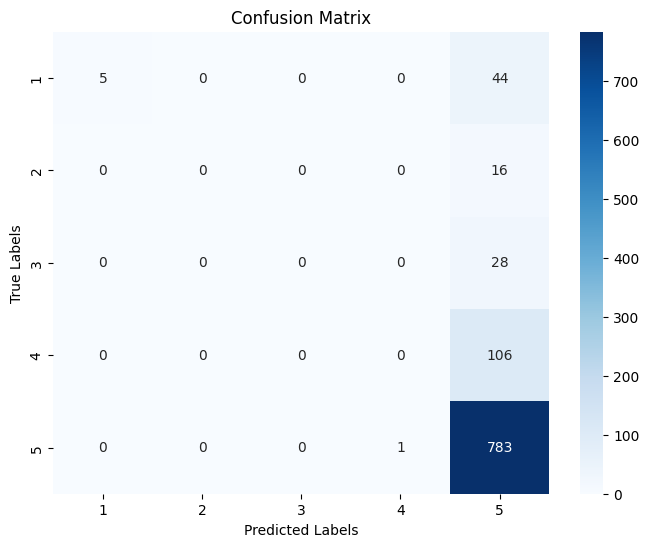

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Identify mismatch indices
mismatch_indices = np.where((y_pred == 5.0) & (y_test == 4.0))[0]

# Access mismatched texts (assuming the original texts are stored in reviews)
mismatched_texts = reviews.iloc[mismatch_indices][['reviewerID','reviewText', 'overall']]

# Filter to print only those with an overall rating of 4.0
filtered_texts = mismatched_texts[mismatched_texts['overall'] == 4.0]

# Print the limited mismatched texts
print("Texts predicted as class 5 but true label is 4.0 (limited to first 10):")
for _, row in limited_texts.iterrows():
    print(f"\nReviewerID: {row['reviewerID']}")
    print(f"ReviewText: {row['reviewText']}")
    print(f"Overall: {row['overall']}")

Texts predicted as class 5 but true label is 4.0 (limited to first 10):

ReviewerID: A3SBTW3WS4IQSN
ReviewText: No issues.
Overall: 4.0

ReviewerID: AKOX2LZVYTAO5
ReviewText: Initially when I inserted the card into the Samsung Galaxy S3 it recognized it but it wasn't able to format it correctly. After doing some research I found a free program EaseUS Partition Master [...] that will format the card into FAT 32 since Windows no longer allows you to do it by default. After formatting it into fat 32 the phone recognized the card and it works great now. I hope this helps anyone else that might run into this problem.
Overall: 4.0

ReviewerID: A16J4XHQ22VE7Q
ReviewText: Performs as it is supposed to. 16gb is quite a lot of storage plus my Samsung Galaxy has 15 gb of internal memory for a total of 32 gb. That's plenty enough to store hundreds of hours of music,
Overall: 4.0

ReviewerID: ASYDHCSXHJAF8
ReviewText: As new products evolve they only accept SD and microSD cards. I've had good luck 